# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, sys, zipfile
project_dir = '/content/drive/MyDrive/AI Project/'
model_dir = project_dir + 'model/'
pkg_dir = project_dir + 'pkgs/'
sys.path.append(pkg_dir)

zip_path = project_dir + "/dataset_zip/dataset.zip"
extract_path = "/content/dataset/"
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# train_dir = project_dir + 'dataset/train/'
# test_dir = project_dir + 'dataset/test/'
train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')

In [ ]:
#!pip install --target='/content/drive/MyDrive/AI Project/pkgs' muspy pypianoroll

import glob, json
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import muspy, pypianoroll
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset

In [ ]:
min_tempo = 25
max_tempo = 500

# Custom Dataset class
class PianorollDataset(Dataset):
    def __init__(self, directory, binary=True, threshold=0.2):
        self.directory = directory
        self.files = os.listdir(directory)
        self.binary = binary
        self.threshold = threshold
        self.trim_length = 12*4*80  # 80 bars

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(os.path.join(self.directory, self.files[idx]))

        inst_class = data['inst_class']
        pianoroll = data['pianoroll']

        key = data['key'] # dim 3
        genre = data['genre'] # dim 10
        tempo = (data['bpm'] - min_tempo) / (max_tempo - min_tempo) # normalization # dim 1
        metadata = np.concatenate((genre, key, tempo), None)

        if self.binary:
            # Convert normalized velocities to binary values
            pianoroll = (pianoroll > self.threshold).astype(float)

        # Trim or pad the sequences to a fixed length
        if inst_class.shape[1] > self.trim_length:
            inst_class = inst_class[:, :self.trim_length]
            pianoroll = pianoroll[:, :, :self.trim_length]
        elif inst_class.shape[1] < self.trim_length:
            padding = self.trim_length - inst_class.shape[1]
            inst_class = np.pad(inst_class, ((0, 0), (0, padding)), mode='constant')
            pianoroll = np.pad(pianoroll, ((0, 0), (0, 0), (0, padding)), mode='constant')

        inst_class = torch.from_numpy(inst_class.transpose(1, 0)).float()  # reshape (5, #timestep) -> (#timestep, 5)
        pianoroll = torch.from_numpy(pianoroll.transpose(2, 0, 1)).float()  # reshape: (17, 128, #timestep) ->  (#timestep, 17, 128)
        pianoroll = pianoroll[:, :, 20:-20] # truncate bottom and top notes
        metadata = torch.from_numpy(metadata).unsqueeze(0).float()  # reshape: (14,) -> (1, 14)
        return inst_class, pianoroll, metadata

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_velocity_distribution(dataset_directory):
    dataset = PianorollDataset(dataset_directory, binary=False)
    histogram = np.zeros(128, dtype=int)

    # Iterate over the dataset
    for _, pianoroll, _ in dataset:
        # Denormalize the velocities
        velocities = (pianoroll.numpy().flatten() * 127).astype(int)

        # Calculate histogram for the current file and add it to the total histogram
        hist, _ = np.histogram(velocities, bins=range(129), density=False)
        histogram += hist

    # The first bin (velocity=0) is not needed
    histogram = histogram[1:]

    plt.bar(range(1, 128), histogram, alpha=0.75)
    plt.xlabel('Velocity')
    plt.ylabel('Frequency')
    plt.title('Velocity Distribution of Pianoroll Notes')
    plt.grid(True)
    plt.show()

#plot_velocity_distribution(test_dir)

In [ ]:
def get_tempo_range(directory):
    files = os.listdir(directory)
    min_tempo, max_tempo = float('inf'), float('-inf')

    for filename in files:
        data = np.load(os.path.join(directory, filename))
        tempo = data['bpm']

        min_tempo = min(min_tempo, tempo)
        max_tempo = max(max_tempo, tempo)

    return min_tempo, max_tempo

# # usage
# min_tempo, max_tempo = get_tempo_range(train_dir)
# print(f"Min Tempo: {min_tempo}, Max Tempo: {max_tempo}")

# Utils

Load Hyperprams Setting

In [ ]:
def load_hyperparams(save_dir):
    # Load hyperparameters from your directory
    with open(f'{save_dir}/hyperparameters.json', 'r') as f:
        hyperparams = json.load(f)
        print("parameters setting is loaded")

    chunk_length = hyperparams['chunk_length']
    num_layers = hyperparams['num_layers']
    hidden_dim = hyperparams['hidden_dim']
    lr = hyperparams['lr']
    batch_size = hyperparams['batch_size']
    epochs = hyperparams['epochs']
    n_test = hyperparams['n_test']
    n_train = hyperparams['n_train']
    checkpoint_num = hyperparams['checkpoint_num']

    return n_train, n_test, epochs, checkpoint_num, batch_size, num_layers, chunk_length, hidden_dim, lr

In [ ]:
import re

# Extract the epoch and batch numbers from the checkpoint name
def extract_numbers_from_checkpoint_name(checkpoint_name):
    match = re.search(r"checkpoint_(\d+)_(\d+).pt", checkpoint_name)
    if match:
        epoch = int(match.group(1))
        batch = int(match.group(2))
        return epoch, batch
    else:
        return 0, 0

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Movig Data to Train/Test Directory

In [ ]:
def move_data():
    source_dir = '/content/drive/MyDrive/AI Project/Clone/AIProject/Dataset'
    # Get a list of files in the directory
    file_list = os.listdir(source_dir)

    # Ensure the target directory exists
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)

    # Move the first 4096 files
    for file_name in file_list[:4096]:
        # construct full file path
        source = os.path.join(source_dir, file_name)
        target = os.path.join(train_dir, file_name)
        
        # move file to the target dir
        os.rename(source, target)

    for file_name in file_list[4096:4352]:
        # construct full file path
        source = os.path.join(source_dir, file_name)
        target = os.path.join(test_dir, file_name)
        
        # move file to the target dir
        os.rename(source, target)

    print("Files moved.")

In [ ]:
def count_files_in_directory(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

# source_dir = '/content/drive/MyDrive/AI Project/Clone/AIProject/Dataset'
# num_files = count_files_in_directory(source_dir)
# print(f"There are {num_files} files in the source directory {source_dir}.")

# num_files = count_files_in_directory(train_dir)
# print(f"There are {num_files} files in the source directory {train_dir}.")

# num_files = count_files_in_directory(test_dir)
# print(f"There are {num_files} files in the source directory {test_dir}.")
# train data = 12288
# test data = 896

Plot Result

In [ ]:
from collections import defaultdict

def plot_result(save_dir):
    # Initialize dictionaries to hold the loaded metrics for each epoch
    train_loss_dict = defaultdict(list)
    train_f1_dict = defaultdict(list)
    eval_losses = []
    eval_f1_scores = []

    # Open the metrics.txt file and read each line
    with open(f'{save_dir}/metrics.txt', 'r') as f:
        for line in f:
            data = line.strip().split(',')
            epoch = int(data[0].split(': ')[1])
            loss = float(data[2].split(': ')[1])
            f1_score = float(data[3].split(': ')[1])

            # Check if the line is from a training or evaluation step
            if "Evaluation" in data[1]:
                # Save the evaluation metrics
                eval_losses.append(loss)
                eval_f1_scores.append(f1_score)
            else:
                # Add training loss and F1 score for each bundle to corresponding epoch
                train_loss_dict[epoch].append(loss)
                train_f1_dict[epoch].append(f1_score)

    # Calculate the average metrics for each epoch
    train_losses = [sum(v)/len(v) for v in train_loss_dict.values()]
    train_f1_scores = [sum(v)/len(v) for v in train_f1_dict.values()]

    # Plot the metrics
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 1, 1)
    plt.plot(train_losses, 'bo-', label='Training Loss', markersize=5)
    plt.plot(eval_losses, 'ro-', label='Evaluation Loss', markersize=5)
    plt.title('Training and Evaluation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(train_f1_scores, 'bo-', label='Training F1 Score', markersize=5)
    plt.plot(eval_f1_scores, 'ro-', label='Evaluation F1 Score', markersize=5)
    plt.title('Training and Evaluation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(save_dir + '/plot.png')
    plt.show()

#plot_result(save_dir)

In [ ]:
# # Calculate the number of 0s and 1s the entire dataset
# num_zeros = 0
# num_ones = 0

# for i, (inst_class, pianoroll, metadata) in enumerate(PianorollDataset(test_dir, threshold=0.2)):
#     num_zeros += (pianoroll == 0).sum().item()
#     num_ones += (pianoroll == 1).sum().item()

#     if i > 100:
#         break
# # Then, calculate the ratio of the number of 0s to the number of 1s
# ratio = num_zeros / num_ones
#print(ratio)
# ratio = 225

In [ ]:
def get_pos_weights():
    # Mean pitch for each track
    mean_pitches = torch.tensor([30, 40, 45, 50, 40, 25, 40, 45, 45, 45, 50, 45, 40, 45, 45, 40, 40], dtype=torch.float32)

    # Initialize standard deviations
    std_devs = torch.full((17,), 10, dtype=torch.float32)  # using 10 as a base standard deviation value

    # Use lower standard deviation for track 0, 15, 16
    std_devs[[0, 15, 16]] = 20

    # Use the mean and std_devs to generate pos_weight
    pos_weights = torch.zeros((17, 88))
    x = torch.arange(88, dtype=torch.float32)
    for i in range(17):
        pos_weights[i] = torch.exp(-((x - mean_pitches[i]) ** 2) / (2 * std_devs[i] ** 2))

    # Normalize pos_weights to range [0, 1]
    pos_weights /= pos_weights.max(dim=1, keepdim=True)[0]

    # for i in range(17):
    #     print(pos_weights[i])

    # Expand pos_weights to the required size
    pos_weights = pos_weights.view(-1)
    
    pos_weights = pos_weights.to(device)

    return pos_weights

In [ ]:
# from pypianoroll import Multitrack, Track
# import muspy

# TRACKCONFIG = (
#     ('Drums', 0),
#     ('Piano', 0),
#     ('Chromatic Percussion', 8),
#     ('Organ', 16),
#     ('Guitar', 24),
#     ('Bass', 32),
#     ('Strings', 40),
#     ('Ensemble', 48),
#     ('Brass', 56),
#     ('Reed', 64),
#     ('Pipe', 72),
#     ('Synth Lead', 80),
#     ('Synth Pad', 88),
#     ('Synth Effects', 96),
#     ('Ethnic', 104),
#     ('Percussive', 112),
#     ('Sound Effects', 120),
# )
# TIMESTEPNUM = 10000
# TRACKNUM = 17
# VELOCITY = 100


# def GenerateMIDI(output, tempo_norm, midi_dir, epoch_num, batch_num):
#     vfunc = lambda v: (v * 127).round()
#     pianoroll = output.transpose(1, 0, 2)
#     tempo = tempo_norm * (max_tempo - min_tempo) + min_tempo

#     tracks = list()
#     for idx in range(TRACKNUM):
#         name, program = TRACKCONFIG[idx]
#         is_drum = (idx == 0)
#         pianoroll = vfunc(pianoroll[idx])
#         track = Track(name=name, program=program, is_drum=is_drum, pianoroll=pianoroll)
#         tracks.append(track)

#     tempo = np.full((TIMESTEPNUM, 1), tempo)
#     multitrack = Multitrack(name='Sample', resolution=12, tempo=tempo, tracks=tracks)
#     mus = muspy.from_pypianoroll(multitrack, VELOCITY)
#     file_path = os.path.join(midi_dir, f'{multitrack.name}_{epoch_num}_{batch_num}.mid')
#     muspy.write_midi(file_path, mus)

In [ ]:
from pypianoroll import Multitrack, Track
import muspy

TRACKCONFIG = (
    ('Drums', 0),
    ('Piano', 0),
    ('Chromatic Percussion', 8),
    ('Organ', 16),
    ('Guitar', 24),
    ('Bass', 32),
    ('Strings', 40),
    ('Ensemble', 48),
    ('Brass', 56),
    ('Reed', 64),
    ('Pipe', 72),
    ('Synth Lead', 80),
    ('Synth Pad', 88),
    ('Synth Effects', 96),
    ('Ethnic', 104),
    ('Percussive', 112),
    ('Sound Effects', 120),
)
TIMESTEPNUM = 10000
TRACKNUM = 17
VELOCITY = 100


def GenerateMIDI(output, tempo_norm, midi_dir):
	vfunc = lambda v: (v * 127).round()
	pianorolls = output.transpose(1, 0, 2)  # shape = (TRACKNUM, TIMESTEPNUM, 128)
	tempo = tempo_norm * (max_tempo - min_tempo) + min_tempo

	tracks = list()
	for idx in range(TRACKNUM):
		name, program = TRACKCONFIG[idx]
		is_drum = (idx == 0)
		pianoroll = vfunc(pianorolls[idx])  # shape = (TIMESTEPNUM, 128)
		track = Track(name=name, program=program, is_drum=is_drum, pianoroll=pianoroll)
		tracks.append(track)
	
	tempo = np.full((TIMESTEPNUM, 1), tempo)
	multitrack = Multitrack(name='Sample', resolution=12, tempo=tempo, tracks=tracks)
	mus = muspy.from_pypianoroll(multitrack, VELOCITY)
	file_path = os.path.join(midi_dir, f'{multitrack.name}.mid')
	muspy.write_midi(file_path, mus)

# Seq2Step3

In [ ]:
class Seq2Step3(nn.Module):
    def __init__(self, input_dim, user_dim, hidden_dim, output_dim, meta_dim, num_layers=2):
        super(Seq2Step3, self).__init__()

        self.hidden_dim = hidden_dim
        self.user_dim = user_dim
        self.num_layers = num_layers
        self.dropout = nn.Dropout(0.25)

        # Encoder LSTM
        self.encoder = nn.LSTM(input_dim, hidden_dim,num_layers=self.num_layers, batch_first=True)

        # Fully connected layer
        self.fc1 = nn.Linear(hidden_dim + user_dim + meta_dim, hidden_dim + user_dim + meta_dim)
        self.fc2 = nn.Linear(hidden_dim + user_dim + meta_dim, output_dim)

    def forward(self, x, user_input, meta, hidden=None, cell=None): # x shape = (batch_size, seq_length, 17*128)
        batch_size = x.size(0)
        
        # Initialize the hidden and cell states
        if hidden is None or cell is None:
            hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
            cell = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        
        # Pass the input through the encoder
        output, (hidden, cell) = self.encoder(x, (hidden, cell))
    
        meta = meta.expand(-1,user_input.size()[1], -1) # shape = (batch_size, #timestep, meta_dim)

        # Concatenate user_input, meta to context vector
        output = torch.cat([output, user_input, meta], dim=2) # shape = (batch_size, #timestep, hidden + input_dim + meta_dim)
        
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        output = self.dropout(output)
        # output shape = (batch_size, #timestep, 17*128)

        return output, hidden, cell

# Seq2Step4

In [ ]:
class Seq2Step4(nn.Module):
    def __init__(self, input_dim, user_dim, hidden_dim, output_dim, meta_dim, num_layers=2):
        super(Seq2Step4, self).__init__()

        self.dropout = nn.Dropout(0.25)
        self.meta_encoder_dim = 10

        # Encoder LSTM
        self.encoder = nn.LSTM(input_dim, hidden_dim,num_layers=num_layers, batch_first=True, bidirectional=True)
        self.meta_encoder = nn.Sequential(
            nn.Linear(user_dim + meta_dim, 32),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(16, self.meta_encoder_dim),
            nn.Dropout(0.2),
            nn.ReLU()
        )
        # Fully connected layer
        self.fc1 = nn.Linear(2*hidden_dim + self.meta_encoder_dim, 2*hidden_dim + self.meta_encoder_dim)
        self.fc2 = nn.Linear(2*hidden_dim + self.meta_encoder_dim, output_dim)
        self.fc3 = nn.Linear(output_dim, output_dim)

    def forward(self, x, user_input, meta, hidden=None, cell=None): # x shape = (batch_size, seq_length, 17*num_notes)
        batch_size = x.size(0)
        
        # Initialize the hidden and cell states
        if hidden is None or cell is None:
            hidden = torch.zeros(2*num_layers, batch_size, hidden_dim).to(device)
            cell = torch.zeros(2*num_layers, batch_size, hidden_dim).to(device)
        
        # Pass the input through the encoder
        output, (hidden, cell) = self.encoder(x, (hidden, cell))
    
        meta = meta.expand(-1,user_input.size()[1], -1) # shape = (batch_size, #timestep, meta_dim)
        meta = torch.cat([meta, user_input], dim=2)
        meta = self.meta_encoder(meta)
        # Concatenate user_input, meta to context vector
        output = torch.cat([output, meta], dim=2) # shape = (batch_size, #timestep, hidden + input_dim + meta_dim)
        
        output = self.fc1(output)
        output = self.dropout(output)
        output = F.relu(output)
        output = self.fc2(output)
        output = F.relu(output)
        output = self.fc3(output) # shape = (batch_size, #timestep, 17*128)
        
        return output, hidden, cell

# Train

In [ ]:
import time
import random
from sklearn.metrics import f1_score

def train(model, batch, optimizer, criterion, chunk_length):
    model.train()

    total_loss = 0
    user_input, pianoroll, meta = batch

    user_input = user_input.to(device)
    pianoroll = torch.flatten(pianoroll, 2).to(device) # flattened shape = (batch_size, #timestep, 17*128)
    meta = meta.to(device)
    
    batch_size = user_input.size(0)

    # Initialize hidden and cell states
    hidden = None
    cell = None

    # for initial timestep
    zero_pianoroll = torch.zeros_like(pianoroll[:, :1]) # shape = (batch_size, #timestemp, 17*128)
    last_pianoroll = None
    first_pianoroll = None

    num_chunks = user_input.size(1) // chunk_length
    
    # Process sequence chunks
    for chunk_index in range(num_chunks):

        chunk_start = chunk_index * chunk_length
        chunk_end = (chunk_index + 1) * chunk_length
        chunk_user_input = user_input[:, chunk_start:chunk_end, :]
        chunk_pianoroll = pianoroll[:, chunk_start:chunk_end, :]

        if chunk_index == 0:
            first_pianoroll = zero_pianoroll
        else:
            first_pianoroll = last_pianoroll

        last_pianoroll = chunk_pianoroll[:,-1,:].unsqueeze(1)
        prev_pianoroll = torch.cat([first_pianoroll, chunk_pianoroll[:,:-1,:]], dim=1) # pianorol starts with empty pianoroll

        output, hidden, cell = model(prev_pianoroll, chunk_user_input, meta, hidden, cell)
        # Compute the loss
        loss = criterion(output, chunk_pianoroll.reshape(batch_size, chunk_length, -1)) # shape: (batch_size, chunk_lengh, #notes*#tracks)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

        hidden = hidden.detach()
        cell = cell.detach()

    total_loss = loss / num_chunks

    return total_loss

Set your directory to save train progress
Since other people can modify nick_name and train_name, you have to change them as yours when you are back.

In [ ]:
 # Your train progress will be saved under "AI Project/model/model_name/{nick_name}/{train_name}"
nick_name = "JYH"
train_name = "final2" # set different train_name for different parameter settings
model_name = Seq2Step4.__name__

save_dir = os.path.join(model_dir, model_name, nick_name, train_name)
checkpoint_dir = os.path.join(save_dir, 'checkpoints')
midi_dir = os.path.join(save_dir, 'MIDIs')

if not os.path.exists(save_dir):
    os.makedirs(checkpoint_dir)
    os.makedirs(midi_dir)
    print(f"directory created: {save_dir}")

Save paremeters setting (raise error when rewriting parameters setting)

In [ ]:
# Set your hyperparameters. Recommend to use values power of 2.
# hidden_dim, batch_size, chunk_length affects GPU memory usage a lot.
hyperparameters_setting = {
    'chunk_length': 12*4*8, # Change only the last value
    'num_layers': 3,
    'hidden_dim': 800,
    'lr': 0.001,
    'batch_size': 64,
    'epochs': 20,
    'n_test': 896,
    'n_train': 12288, 
    'checkpoint_num': 2,
}
filepath = f'{save_dir}/hyperparameters.json'

disable_overwrite = True

# Check if the file already exists
if os.path.isfile(filepath) and disable_overwrite:
    sys.exit(f"Error: {filepath} already exists. Hyperparameters not saved to avoid overwriting.")
else:
    # Save as a json file
    with open(filepath, 'w') as f:
        json.dump(hyperparameters_setting, f)
        print(f"Hyperparameters setting saved to: {filepath}")

SystemExit: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# Load model
n_train, n_test, epochs, checkpoint_num, batch_size, num_layers, chunk_length, hidden_dim, lr = load_hyperparams(save_dir)
checkpoint_interval = n_train / batch_size / checkpoint_num
model = Seq2Step4(input_dim=17*88, meta_dim=14, user_dim=5, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=17*88).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

max_weight = 100
min_weight = 50
weight_decay = (max_weight - min_weight) / epochs
weight_offset = get_pos_weights()
                         
print(f'The model has {count_parameters(model)} parameters')

In [ ]:
# Load data
train_dataset = PianorollDataset(train_dir)
train_subset = Subset(train_dataset, range(n_train))

test_dataset = PianorollDataset(test_dir)
test_subset = Subset(test_dataset, range(n_test))

In [ ]:
# Check for existing checkpoints
checkpoints = glob.glob(checkpoint_dir + "/checkpoint_*.pt")
#checkpoints.sort(key=lambda name: int(name.split("_")[1].split(".")[0]))

start_batch = 0
start_epoch = 0
shuffled_indices = list(range(len(train_subset)))
if checkpoints:
    # Load the most recent checkpoint
    checkpoint_path = checkpoints[-1]
    checkpoint = torch.load(checkpoint_path)
    
    # Restore the state of the model and optimizer
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Continue training from the checkpoint
    start_epoch = checkpoint['epoch']
    start_batch = checkpoint['last_batch'] + 1
    shuffled_indices = checkpoint['shuffled_indices']

    num_batch = len(shuffled_indices) / batch_size
    if start_batch >= num_batch:
        start_epoch += 1
        start_batch = 0

    print(f"Continue training from checkpoint: epoch {start_epoch}, batch {start_batch}")
else:
    print("Start new training")

In [ ]:
for epoch in range(start_epoch, epochs):
    # Shuffle indices at the start of each epoch
    if epoch != start_epoch or not checkpoints:
        random.shuffle(shuffled_indices)
    
    pos_weight = weight_offset * max(max_weight - weight_decay * epoch, min_weight)
    pos_weight = pos_weight.to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    subset_sampler = SubsetRandomSampler(shuffled_indices)
    data_loader = DataLoader(train_subset, batch_size=batch_size, sampler=subset_sampler)
    data_loader = tqdm(data_loader)
    
    for i, batch in enumerate(data_loader):
        # Skip the batches before the start_batch for the first epoch if resuming from a checkpoint
        if epoch == start_epoch and i < start_batch:
            continue

        batch_loss = train(model, batch, optimizer, criterion, chunk_length=chunk_length)

        if (i + 1)% checkpoint_interval == 0:
            torch.save({
                'epoch': epoch,
                'last_batch': i,
                'shuffled_indices': shuffled_indices,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, checkpoint_dir + f"/checkpoint_{epoch}_{i}.pt")
            
            with open(f'{save_dir}/metrics.txt', 'a') as f:
                f.write(f"Epoch: {epoch}, batch: {i}, Loss: {batch_loss}\n") 

print('Train Finished')

# Evaluation

In [ ]:
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
from os import PathLike
from typing import List, Tuple, Union
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay, DetCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt


TRACK2INST = [0, 2, 0, 3, 2, 1, 2, 3, 2, 2, 2, 2, 3, 4, 2, 0, 4]
DRUMDISTRIBUTION = [0.3739603, 0.00369717, 0.05161105, 0.05632562, 0.02407182, 0.00486619, 0.30184058, 0.00466669, 0.08540609, 0.06848897, 0.01867757, 0.00638795]


def calculate_score(y_true: ArrayLike, y_pred: ArrayLike) -> Tuple[float, float, float, float]:
    """
    Calculate accuracy, precision, recall, and F1 score.

    Args:
        y_true: Array of true labels.
        y_pred: Array of predicted labels.

    Returns:
        Tuple of accuracy, precision, recall, and F1 score.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1, average='micro')
    recall = recall_score(y_true, y_pred, zero_division=1, average='micro')
    f1 = f1_score(y_true, y_pred, zero_division=1, average='micro')
    return accuracy, precision, recall, f1

def calculate_distribution_similarity(dist1: ArrayLike, dist2: ArrayLike) -> Tuple[float, float, float]:
    """
    Calculate distribution similarity using Jensen-Shannon Divergence (JSD), Earth Mover's Distance (EMD),
    and Cosine Similarity.

    Args:
        dist1: Array representing the first distribution.
        dist2: Array representing the second distribution.

    Returns:
        Tuple of JSD score, EMD score, and cosine similarity score.
    """
    jsd_score = jensenshannon(dist1, dist2)
    emd_score = wasserstein_distance(dist1, dist2)
    cosine_score = cosine_similarity([dist1], [dist2])[0][0]
    return jsd_score, emd_score, cosine_score

def plot_confusion_matrix(y_true, y_pred, save_dir: PathLike = None, save=False, show=False):
    """
    Plot and display the confusion matrix.

    Args:
        y_true: Array of true labels.
        y_pred: Array of predicted labels.
        save_dir: Directory to save the plot (optional).
        save: Whether to save the plot (optional).
        show: Whether to display the plot (optional).
    """
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues')
    if save: plt.savefig(Path(save_dir) / 'Confusion_Matrix.png')
    if show: plt.show()

def plot_precision_recall(y_true, y_pred, save_dir: PathLike = None, save=False, show=False):
    """
    Plot and display the precision-recall curve.

    Args:
        y_true: Array of true labels.
        y_pred: Array of predicted labels.
        save_dir: Directory to save the plot (optional).
        save: Whether to save the plot (optional).
        show: Whether to display the plot (optional).
    """
    PrecisionRecallDisplay.from_predictions(y_true, y_pred)
    plt.legend().remove()
    if save: plt.savefig(Path(save_dir) / 'Precision_Recall.png')
    if show: plt.show()

def plot_roc_curve(y_true, y_pred, save_dir: PathLike = None, save=False, show=False):
    """
    Plot and display the ROC curve.

    Args:
        y_true: Array of true labels.
        y_pred: Array of predicted labels.
        save_dir: Directory to save the plot (optional).
        save: Whether to save the plot (optional).
        show: Whether to display the plot (optional).
    """
    RocCurveDisplay.from_predictions(y_true, y_pred)
    plt.legend().remove()
    if save: plt.savefig(Path(save_dir) / 'Roc_Curve.png')
    if show: plt.show()

def plot_det_curve(y_true, y_pred, save_dir: PathLike = None, save=False, show=False):
    """
    Plot and display the DET curve.

    Args:
        y_true: Array of true labels.
        y_pred: Array of predicted labels.
        save_dir: Directory to save the plot (optional).
        save: Whether to save the plot (optional).
        show: Whether to display the plot (optional).
    """
    DetCurveDisplay.from_predictions(y_true, y_pred)
    plt.legend().remove()
    if save: plt.savefig(Path(save_dir) / 'Det_Curve.png')
    if show: plt.show()

def plot_distribution(dist, save_dir: PathLike = None, save=False, show=False):
    """
    Plot and display the distribution.

    Args:
        dist: Array representing the distribution.
        save_dir: Directory to save the plot (optional).
        save: Whether to save the plot (optional).
        show: Whether to display the plot (optional).
    """
    x = np.arange(1, len(dist) + 1)
    plt.bar(x, dist)
    plt.xlabel('Timestep')
    plt.ylabel('Probability')
    plt.xticks(x)
    plt.legend().remove()
    if save: plt.savefig(Path(save_dir) / 'Distribution.png')
    if show: plt.show()

def safe_plot(func):
    """
    Decorator to handle exceptions when plotting.

    Args:
        func: Function to be decorated.

    Returns:
        Decorated function.
    """
    def wrapper(*args, **kwargs):
        try:
            func(*args, **kwargs)
        except ValueError:
            pass
    return wrapper

class ScoreSheet:
    def __init__(self, im_score, ir_score, dp_score, name='ScoreSheet') -> None:
        self.im_score = im_score
        self.ir_score = ir_score
        self.dp_score = dp_score
        self.name = name
        self.sheet = self.make_sheet()
    
    def __str__(self) -> str:
        return str(self.sheet)
    
    def make_sheet(self) -> pd.DataFrame:
        """
        Create a score sheet DataFrame.

        Returns:
            DataFrame representing the score sheet.
        """
        sheet = pd.DataFrame({
            'Test': [
                'IM Test', 'IM Test', 'IM Test', 'IM Test',
                'IR Test', 'IR Test', 'IR Test', 'IR Test',
                'DP Test', 'DP Test', 'DP Test',
            ],
            'Metric': [
                'Accuracy', 'Precision', 'Recall', 'F1 Score',
                'Accuracy', 'Precision', 'Recall', 'F1 Score',
                'Jensen-Shannon Divergence', "Earth Mover's Distance", 'Cosine Similarity',
            ],
            'Score': [
                self.im_score[0], self.im_score[1], self.im_score[2], self.im_score[3],
                self.ir_score[0], self.ir_score[1], self.ir_score[2], self.ir_score[3],
                self.dp_score[0], self.dp_score[1], self.dp_score[2],
            ]
        })
        return sheet

    def save(self, save_dir: PathLike):
        """
        Save the score sheet as a CSV file.

        Args:
            save_dir: Directory to save the score sheet.
        """
        self.sheet.to_csv(Path(save_dir) / f'{self.name}.csv', index=False)


class TestTaker:
    def __init__(self, inst_class: np.ndarray, output: np.ndarray, name='TestTaker') -> None:
        """
        Initializes a TestTaker object.

        Args:
            inst_class: Numpy array of shape (5, #timestep) representing the class of each instrument at each timestep.
            output: Numpy array of shape (17, 128, #timestep) representing the output of the model.
            name (optional): Name of the TestTaker. Defaults to 'TestTaker'.
        """
        self.inst_class = inst_class  # Transpose inst_class to shape (#timestep, 5)
        # output = output.transpose(2, 0, 1)  # Transpose output to shape (#timestep, 17, 128)
        
        # Determine if each track is active at each timestep
        self.output: np.ndarray = np.any(output != 0, axis=2)  # shape (#timestep, 17)
        
        self.name = name
        self.timesteps = self.inst_class.shape[0]
        self.sheet: ScoreSheet = None
    
    def grade_score(self, im_score: Tuple, ir_score: Tuple, dp_score: Tuple) -> None:
        """
        Grades the scores of the test.

        Args:
            im_score: Tuple of scores for Input Match Test.
            ir_score: Tuple of scores for Input Response Test.
            dp_score: Tuple of scores for Drum Pattern Test.
        """
        self.sheet = ScoreSheet(im_score, ir_score, dp_score, self.name)
    
    def get_score(self):
        return self.sheet.im_score, self.sheet.ir_score, self.sheet.dp_score
    
    def print_score(self):
        """
        Prints the score sheet.
        """
        print(self.sheet)
    
    def save_score(self, save_dir: PathLike):
        """
        Saves the score sheet as a CSV file.

        Args:
            save_dir: Directory path to save the CSV file.
        """
        self.sheet.save(save_dir)


class Evaluator:
    def __init__(self, root: PathLike) -> None:
        """
        Initializes an Evaluator object.

        Args:
            root: Root directory path.
        """
        self.root = Path(root)
        
        # Result Plot Directory
        self.im_dir = Path(root) / 'IMTest'
        self.ir_dir = Path(root) / 'IRTest'
        self.dp_dir = Path(root) / 'DPTest'
        for test_path in [self.im_dir, self.ir_dir, self.dp_dir]:
            test_path.mkdir(parents=True, exist_ok=True)
        
        # Result
        self.im_true, self.im_pred, self.ir_true, self.ir_pred = [], [], [], []
        self.dp_pred = np.zeros(12)
        self.sheet: ScoreSheet = None
    
    def __call__(self, taker: TestTaker):
        """
        Evaluates a TestTaker object.

        Args:
            taker: The TestTaker object to evaluate.
        """
        im_score = self.IMTest(taker)
        ir_score = self.IRTest(taker)
        dp_score = self.DPTest(taker)
        taker.grade_score(im_score, ir_score, dp_score)

    def IMTest(self, taker: TestTaker) -> Tuple[float, float, float, float]:
        '''
        Input Match Test

        Args:
            taker: The TestTaker object to evaluate.

        Returns:
            Tuple of IMTest scores: (accuracy, precision, recall, f1_score).
        '''
        y_true = []
        y_pred = []
        for timestep in range(taker.timesteps):
            insts = taker.inst_class[timestep]
            pred_insts = np.zeros(5)
            tracks = taker.output[timestep]
            for idx, track in enumerate(tracks):
                inst = TRACK2INST[idx]
                ori = pred_insts[inst]
                pred_insts[inst] = max(ori, int(track))
            y_true.extend(insts)
            y_pred.extend(pred_insts)
        self.im_true.extend(y_true), self.im_pred.extend(y_pred)
        im_score = calculate_score(y_true, y_pred)
        return im_score
                
    
    def IRTest(self, taker: TestTaker) -> Tuple[float, float, float, float]:
        '''
        Input Response Test

        Args:
            taker: The TestTaker object to evaluate.

        Returns:
            Tuple of IMTest scores: (accuracy, precision, recall, f1_score).
        '''
        y_true = []
        y_pred = []
        for timestep in range(taker.timesteps):
            insts = taker.inst_class[timestep]
            tracks = taker.output[timestep]
            label = np.any(insts)
            predict = np.any(tracks)
            y_true.append(label)
            y_pred.append(predict)

        self.ir_true.extend(y_true), self.ir_pred.extend(y_pred)
        ir_score = calculate_score(y_true, y_pred)
        return ir_score
            
    
    def DPTest(self, taker: TestTaker) -> Tuple[float, float, float]:
        '''
        Drum Pattern Test

        Args:
            taker: The TestTaker object to evaluate.

        Returns:
            Tuple of DPTest scores: (JSD score, EMD score, cosine similarity score).
        '''
        drums: np.ndarray = taker.output.T[0]
        y_pred = np.zeros(12)
        if drums.any():
            num_iterations = taker.timesteps // 12
            for iter in range(num_iterations):
                beat = drums[iter * 12:(iter + 1) * 12]
                true_indices = np.where(beat)[0]
                y_pred[true_indices] += 1
            total_sum = np.sum(y_pred)
            dp_dist = y_pred / total_sum
            dp_score = calculate_distribution_similarity(DRUMDISTRIBUTION, dp_dist)
            self.dp_pred += y_pred
        else:
            dp_score = (0, 0, 0)
        return dp_score
    
    def calculate_total_score(self):
        """
        Calculate the total score combining scores from different tests.

        Computes the scores for input match test (IMTest), input response test (IRTest), and drum pattern test (DPTest).
        If drum pattern predictions are available, it calculates the drum pattern score using distribution similarity.
        Creates a ScoreSheet object with the computed scores and assigns it to the `sheet` attribute.

        Returns:
            None
        """
        im_score = calculate_score(self.im_true, self.im_pred)
        ir_score = calculate_score(self.ir_true, self.ir_pred)
        if self.dp_pred.any():
            total_sum = np.sum(self.dp_pred)
            dp_dist = self.dp_pred / total_sum
            dp_score = calculate_distribution_similarity(DRUMDISTRIBUTION, dp_dist)
        else:
            dp_score = (0, 0, 0)
        self.sheet = ScoreSheet(im_score, ir_score, dp_score, 'Total')

    def get_total_score(self):
        return self.sheet.im_score, self.sheet.ir_score, self.sheet.dp_score

    def print_total_score(self):
        """
        Print the total score.

        Prints the score sheet (self.sheet) containing the total score.

        Returns:
            None
        """
        print(self.sheet)
    
    def save_total_score(self):
        """
        Save the total score.

        Saves the score sheet (self.sheet) containing the total score to the root directory.

        Returns:
            None
        """
        self.sheet.save(self.root)
    
    def plot_total(self, save=False, show=False):
        """
        Plot the total scores.

        Plots the evaluation metrics for input match test (IMTest), input response test (IRTest),
        and drum pattern test (DPTest). Optionally saves the plots and/or shows them.

        Args:
            save (bool): Whether to save the plots. Default is False.
            show (bool): Whether to show the plots. Default is False.

        Returns:
            None
        """
        self.plot_IMTest(save, show)
        self.plot_IRTest(save, show)
        self.plot_DPTest(save, show)
    
    @safe_plot
    def plot_IMTest(self, save=False, show=False):
        """
        Plot the evaluation metrics for input match test (IMTest).

        Plots the confusion matrix, precision-recall curve, ROC curve, and DET curve for the IMTest.
        Optionally saves the plots and/or shows them.

        Args:
            save (bool): Whether to save the plots. Default is False.
            show (bool): Whether to show the plots. Default is False.

        Returns:
            None
        """
        plot_confusion_matrix(self.im_true, self.im_pred, self.im_dir, save, show)
        plot_precision_recall(self.im_true, self.im_pred, self.im_dir, save, show)
        plot_roc_curve(self.im_true, self.im_pred, self.im_dir, save, show)
        plot_det_curve(self.im_true, self.im_pred, self.im_dir, save, show)
    
    @safe_plot
    def plot_IRTest(self, save=False, show=False):
        """
        Plot the evaluation metrics for input response test (IRTest).

        Plots the confusion matrix, precision-recall curve, ROC curve, and DET curve for the IRTest.
        Optionally saves the plots and/or shows them.

        Args:
            save (bool): Whether to save the plots. Default is False.
            show (bool): Whether to show the plots. Default is False.

        Returns:
            None
        """
        plot_confusion_matrix(self.ir_true, self.ir_pred, self.ir_dir, save, show)
        plot_precision_recall(self.ir_true, self.ir_pred, self.ir_dir, save, show)
        plot_roc_curve(self.ir_true, self.ir_pred, self.ir_dir, save, show)
        plot_det_curve(self.ir_true, self.ir_pred, self.ir_dir, save, show)
    
    @safe_plot
    def plot_DPTest(self, save, show):
        """
        Plot the evaluation metrics for drum pattern test (DPTest).

        Plots the drum pattern distribution.
        If drum pattern predictions are available, it plots the distribution using the predicted values.
        Optionally saves the plots and/or shows them.

        Args:
            save (bool): Whether to save the plots. Default is False.
            show (bool): Whether to show the plots. Default is False.

        Returns:
            None
        """
        if self.dp_pred.any():
            total_sum = np.sum(self.dp_pred)
            dp_dist = self.dp_pred / total_sum
        else:
            dp_dist = np.zeros_like(self.dp_pred)
        plot_distribution(dp_dist, self.dp_dir, save, show)

In [ ]:
def evaluate_teacher_forcing(model, batch, criterion, chunk_length):
    model.train()

    total_loss = 0
    user_input, pianoroll, meta = batch

    pred_chunk = []
    user_input = user_input.to(device)
    pianoroll = torch.flatten(pianoroll, 2).to(device) # flattened shape = (batch_size, #timestep, 17*128)
    meta = meta.to(device)
    
    batch_size = user_input.size(0)

    # Initialize hidden and cell states
    hidden = None
    cell = None

    # for initial timestep
    zero_pianoroll = torch.zeros_like(pianoroll[:, :1]) # shape = (batch_size, #timestemp, 17*128)
    last_pianoroll = None
    first_pianoroll = None

    num_chunks = user_input.size(1) // chunk_length
    
    # Process sequence chunks
    for chunk_index in range(num_chunks):

        chunk_start = chunk_index * chunk_length
        chunk_end = (chunk_index + 1) * chunk_length
        chunk_user_input = user_input[:, chunk_start:chunk_end, :]
        chunk_pianoroll = pianoroll[:, chunk_start:chunk_end, :]

        if chunk_index == 0:
            first_pianoroll = zero_pianoroll
        else:
            first_pianoroll = last_pianoroll

        last_pianoroll = chunk_pianoroll[:,-1,:].unsqueeze(1)
        prev_pianoroll = torch.cat([first_pianoroll, chunk_pianoroll[:,:-1,:]], dim=1) # pianorol starts with empty pianoroll

        output, hidden, cell = model(prev_pianoroll, chunk_user_input, meta, hidden, cell)
        output.cpu()
        pred_chunk.append(output)
        # Compute the loss
        loss = criterion(output, chunk_pianoroll.reshape(batch_size, chunk_length, -1)) # shape: (batch_size, chunk_lengh, #notes*#tracks)
        total_loss += loss.item()

        hidden = hidden.detach()
        cell = cell.detach()

    total_loss = loss / num_chunks
    return pred_chunk, total_loss

In [ ]:
def predict(model, user_input, meta, steps):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()

    initial_pianoroll = torch.zeros((1, 1, 17*88))
    pianoroll = initial_pianoroll.to(device)
    pianoroll_sequence = pianoroll
    user_input = user_input.to(device) # shape = (batch_size, #timesetep, 5)
    meta = meta.to(device)
    avg_time = 0
    with torch.no_grad():
        hidden = None
        cell = None

        start_time = time.time()
        # Process one timestep at a time
        for t in range(steps):
            pianoroll, hidden, cell = model(pianoroll, user_input[:, t, :].unsqueeze(1), meta, hidden, cell) # pianoroll is single time step.
            pianoroll_sequence = torch.cat([pianoroll_sequence, pianoroll], dim=1) # shape = (batch_size, #accumulated timesteps, #notes*#tracks)
            # Detach hidden and cell states
            hidden = hidden.detach()
            cell = cell.detach()

        end_time = time.time()
        avg_time = (end_time - start_time) / steps
    #print(f"Average Process Time: {avg_time*1000:.1f} ms")
    #pianoroll = pianoroll.view(batch_size, -1, 17, 128).cpu().numpy()
    prob = torch.sigmoid(pianoroll_sequence)
    pred = (prob > 0.5).float()

    return pred.cpu().numpy()

In [ ]:
n_train, n_test, epochs, checkpoint_num, batch_size, num_layers, chunk_length, hidden_dim, lr = load_hyperparams(save_dir)
model = Seq2Step4(input_dim=17*88, meta_dim=14, user_dim=5, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=17*88).to(device)

checkpoints.sort(key=extract_numbers_from_checkpoint_name)
epoch = 0
batch_num = 0
if checkpoints:
    # Load the most recent checkpoint
    checkpoint_path = checkpoints[-1]
    checkpoint = torch.load(checkpoint_path)

    epoch, batch_num = extract_numbers_from_checkpoint_name(checkpoint_path)
    print(f"Loaded checkpoint from epoch {epoch}, batch {batch_num}")

    # Restore the state of the model and optimizer
    model.load_state_dict(checkpoint['model_state_dict'])

print(f'The model has {count_parameters(model)} parameters')

In [ ]:
steps = 12*4*8

test_dataset = PianorollDataset(test_dir)
test_subset = Subset(test_dataset, range(128))
test_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

epoch = 
eval_dir = save_dir + f'/eval/{epoch}'
evaluator = Evaluator(save_dir)

for i, (user_input, y, metadata) in enumerate(test_loader):
    y = y.squeeze(0)[:steps].cpu().numpy().astype(int)
    user_input = user_input[:, :steps, :]
    tempo_norm = metadata.numpy()[0][-1][-1]

    pianoroll = predict(model, user_input, metadata, steps) # shape = (batch_size, seq_len, 17*88)
    pianoroll = np.reshape(pianoroll, (pianoroll.shape[0], pianoroll.shape[1], 17, 88)) # shape = (batch_size, seq_len, 17, 88)
    pianoroll = np.transpose(pianoroll, (1,2,3,0))
    pianoroll = np.squeeze(pianoroll, axis=3)

    # pad the array
    pad_width = 20
    pianoroll = np.pad(pianoroll, ((0, 0), (0, 0), (pad_width, pad_width)))
    pianoroll = pianoroll[1:,:,:].astype(int) # shape = (384, 17, 128) # exclude first empty pianoroll.
    
    user_input = user_input.squeeze(0).cpu().numpy()
    test_taker = TestTaker(user_input, pianoroll)
    evaluator(test_taker)

# Calculate total score after all test_takers have been evaluated
evaluator.calculate_total_score()

# Print and save total score
evaluator.print_total_score()
evaluator.save_total_score()

# Plot total scores
evaluator.plot_total(save=True, show=True)

In [ ]:
n_train, n_test, epochs, checkpoint_num, batch_size, num_layers, chunk_length, hidden_dim, lr = load_hyperparams(save_dir)
model = Seq2Step4(input_dim=17*88, meta_dim=14, user_dim=5, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=17*88).to(device)

checkpoints.sort(key=extract_numbers_from_checkpoint_name)

steps = 12*4*8

test_dataset = PianorollDataset(test_dir)
test_subset = Subset(test_dataset, range(128))
test_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

for checkpoint_path in checkpoints:
    checkpoint = torch.load(checkpoint_path)
    epoch, batch_num = extract_numbers_from_checkpoint_name(checkpoint_path)
    print(f"Loaded checkpoint from epoch {epoch}, batch {batch_num}")

    # Restore the state of the model
    model.load_state_dict(checkpoint['model_state_dict'])

    eval_dir = os.path.join(save_dir, f'eval/epoch_{epoch}')
    if not os.path.exists(eval_dir):
        os.makedirs(eval_dir)
    evaluator = Evaluator(eval_dir)

    for i, (user_input, y, metadata) in enumerate(test_loader):
        y = y.squeeze(0)[:steps].cpu().numpy().astype(int)
        user_input = user_input[:, :steps, :]
        tempo_norm = metadata.numpy()[0][-1][-1]

        pianoroll = predict(model, user_input, metadata, steps) # shape = (batch_size, seq_len, 17*88)
        
        # reshape the array
        pianoroll = np.reshape(pianoroll, (pianoroll.shape[0], pianoroll.shape[1], 17, 88)) # shape = (batch_size, seq_len, 17, 88)
        pianoroll = np.transpose(pianoroll, (1,2,3,0))
        pianoroll = np.squeeze(pianoroll, axis=3)
        pad_width = 20
        pianoroll = np.pad(pianoroll, ((0, 0), (0, 0), (pad_width, pad_width)))
        pianoroll = pianoroll[1:,:,:].astype(int) # shape = (384, 17, 128) # exclude first empty pianoroll.
        user_input = user_input.squeeze(0).cpu().numpy()
        test_taker = TestTaker(user_input, pianoroll)
        
        evaluator(test_taker)

    # Calculate total score after all test_takers have been evaluated
    evaluator.calculate_total_score()

    # Print and save total score
    evaluator.print_total_score()
    evaluator.save_total_score()

    # Plot total scores
    evaluator.plot_total(save=True, show=True)

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Directory where the evaluation results are stored
eval_dir = os.path.join(save_dir, 'eval/')
# Lists to store the metrics for each epoch
epochs = []
im_f1_scores = []
ir_f1_scores = []
dp_js_divergences = []
dp_em_distances = []

# Iterate over each directory in the evaluation directory
for dirname in os.listdir(eval_dir):
    # Extract the epoch number from the directory name
    epoch = int(dirname.split('_')[-1])
    epochs.append(epoch)

    # Load the Total.csv file for this epoch
    total_csv_path = os.path.join(eval_dir, dirname, 'Total.csv')
    df = pd.read_csv(total_csv_path)

    # Extract the desired metrics
    im_f1_score = df.loc[(df['Test'] == 'IM Test') & (df['Metric'] == 'F1 Score'), 'Score'].values[0]
    ir_f1_score = df.loc[(df['Test'] == 'IR Test') & (df['Metric'] == 'F1 Score'), 'Score'].values[0]
    dp_js_divergence = df.loc[(df['Test'] == 'DP Test') & (df['Metric'] == 'Jensen-Shannon Divergence'), 'Score'].values[0]
    dp_em_distance = df.loc[(df['Test'] == 'DP Test') & (df['Metric'] == "Earth Mover's Distance"), 'Score'].values[0]

    # Append the metrics to the lists
    im_f1_scores.append(im_f1_score)
    ir_f1_scores.append(ir_f1_score)
    dp_js_divergences.append(dp_js_divergence)
    dp_em_distances.append(dp_em_distance)

# Plot the metrics over time
plt.figure(figsize=(10, 6))
plt.plot(epochs, im_f1_scores, label='IM F1 Score')
plt.plot(epochs, ir_f1_scores, label='IR F1 Score')
plt.plot(epochs, dp_js_divergences, label='DP Jensen-Shannon Divergence')
plt.plot(epochs, dp_em_distances, label="DP Earth Mover's Distance")
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.show()

# Test

In [ ]:
steps = 12*4*8
test_dataset = PianorollDataset(train_dir)
random_index = random.randint(0, len(test_dataset)-1)
user_input, y, metadata = test_dataset[random_index]
y = y[:steps]

user_input = user_input.unsqueeze(0)
metadata = metadata.unsqueeze(0)
tempo_norm = metadata.numpy()[0][-1][-1]

pianoroll = predict(model, user_input, metadata, steps) # shape = (batch_size, seq_len, 17*88)
pianoroll = np.reshape(pianoroll, (pianoroll.shape[0], pianoroll.shape[1], 17, 88)) # shape = (batch_size, seq_len, 17, 88)
pianoroll = np.transpose(pianoroll, (1,2,3,0))
pianoroll = np.squeeze(pianoroll, axis=3)

# pad the array
pad_width = 20
pianoroll = pianoroll[1:,:,:] # shape = (384, 17, 128) # exclude first empty pianoroll.
pianoroll = np.pad(pianoroll, ((0, 0), (0, 0), (pad_width, pad_width)))
GenerateMIDI(pianoroll, tempo_norm, midi_dir)

In [ ]:
import numpy as np
nonzero = np.count_nonzero(pianoroll)
print(nonzero)

In [ ]:
n_train, n_test, epochs, checkpoint_num, _, num_layers, chunk_length, hidden_dim, lr = load_hyperparams(save_dir)
batch_size = 1
# Load data
test_dataset = PianorollDataset(test_dir)
test_subset = Subset(test_dataset, range(1))
test_data_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=True)

checkpoints = sorted(glob.glob(checkpoint_dir + "/checkpoint_*.pt"))
start_epoch = 0
last_loaded_epoch = -1  # Track last loaded epoch

# Create model
model = Seq2Step3(input_dim=17*88, meta_dim=14, user_dim=5, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=17*88).to(device)
print(f'The model has {count_parameters(model)} parameters')

steps = 12*4*8

# Loop over each checkpoint
for checkpoint_path in checkpoints:
    # Extract epoch number from checkpoint filename
    epoch_num = int(checkpoint_path.split('_')[-2])

    # Only evaluate the first checkpoint for each epoch
    if epoch_num != last_loaded_epoch:
        last_loaded_epoch = epoch_num

        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path)

        # Restore the state of the model
        model.load_state_dict(checkpoint['model_state_dict'])
        last_pianoroll = None
        for i, (user_input, _, metadata) in enumerate(test_data_loader):
            pianoroll = predict(model, user_input, metadata, steps)
            pianoroll = np.reshape(pianoroll, (pianoroll.shape[0], pianoroll.shape[1], 17, 88)) # shape (batch_size, steps, 17,  88)
            last_pianoroll = pianoroll[0] # only takes one item of from each batch

            # Pad the array
            pad_width = 20
            last_pianoroll = np.pad(last_pianoroll, ((0, 0), (0, 0), (pad_width, pad_width)))
            last_pianoroll = last_pianoroll[1:,:,:]
            tempo_norm = metadata.numpy()[0][-1][-1]
        GenerateMIDI(last_pianoroll, tempo_norm, midi_dir)

        # Add your evaluation code here...
        # Evaluate the model...


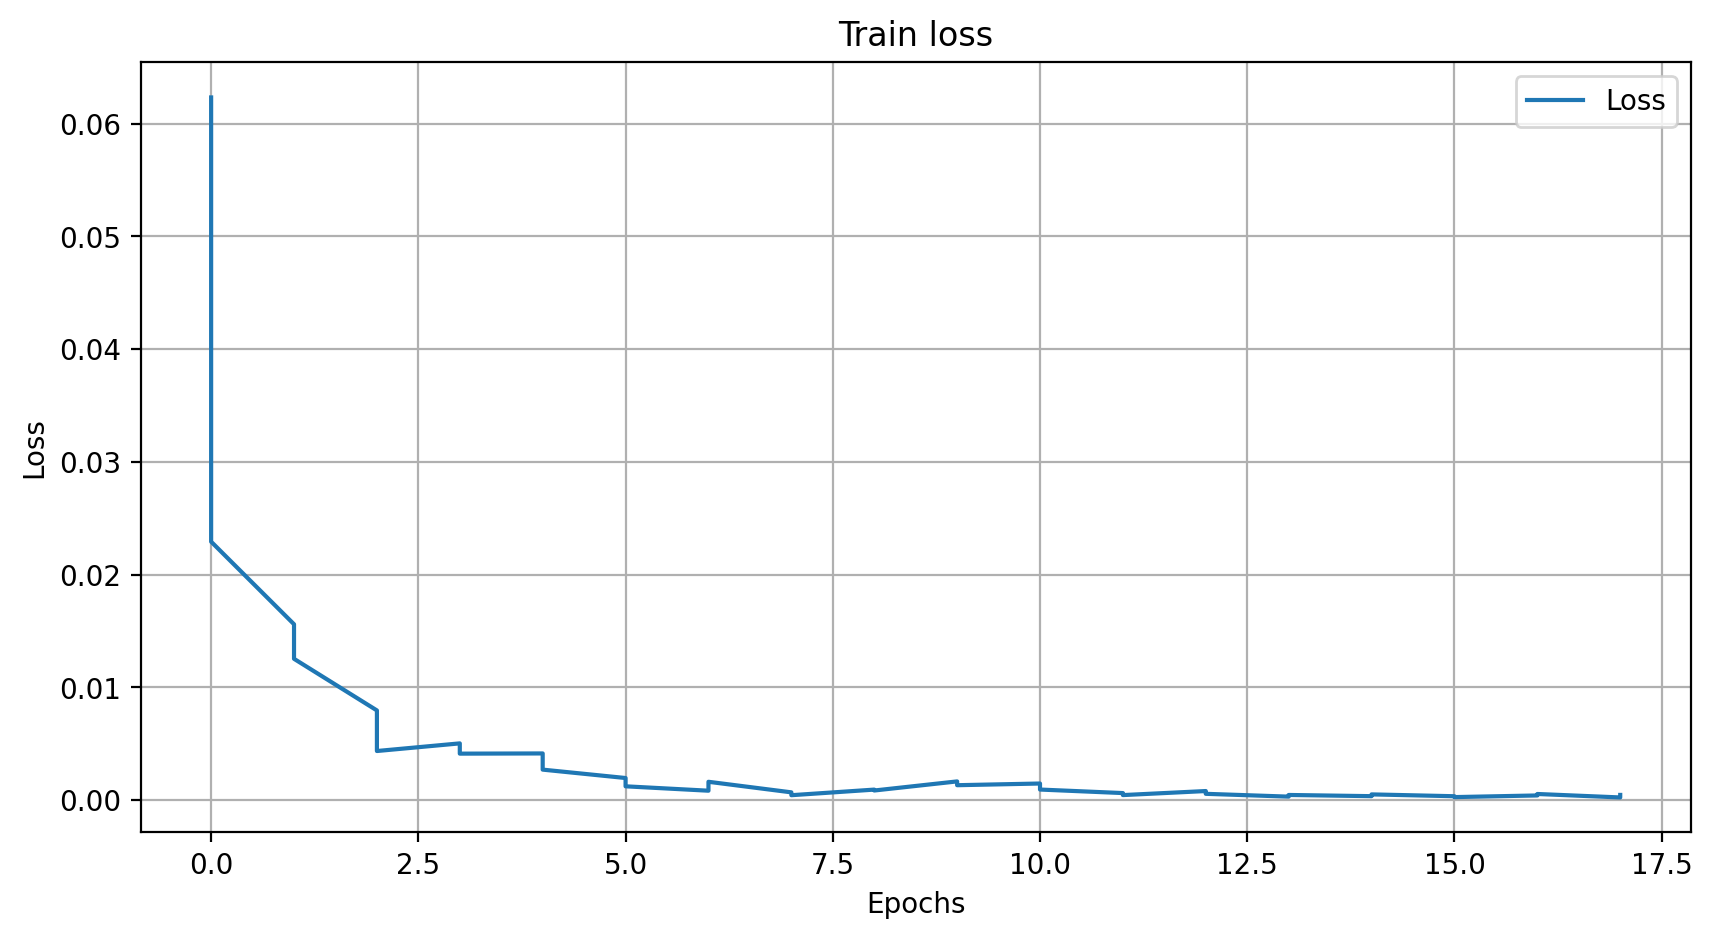

In [ ]:
import matplotlib.pyplot as plt
import re

def parse_loss_log(filename):
    with open(filename, 'r') as file:
        logs = file.read()

    # Extract all losses with their corresponding epochs
    losses = re.findall(r"Epoch: (\d+), batch: \d+, Loss: (\d+\.\d+)", logs)

    # Sort by epochs
    losses.sort(key=lambda x: int(x[0]))

    # Split into separate lists
    epochs, loss_values = zip(*losses)
    
    # Convert string lists to int/float lists for plotting
    epochs = [int(epoch) for epoch in epochs]
    loss_values = [float(loss) for loss in loss_values]
    
    return epochs, loss_values

def plot_loss(epochs, loss_values):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss_values, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# The path to your log file
log_file_path = f'{save_dir}/metrics.txt'  

epochs, loss_values = parse_loss_log(log_file_path)
plot_loss(epochs, loss_values)